# load dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import requests
import io
from typing import Tuple, Dict, List
from torchinfo import summary
import tqdm
import matplotlib.pyplot as plt

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:

    
# Downloading the csv file from your GitHub account

url = "https://raw.githubusercontent.com/krishnaik06/Stock-MArket-Forecasting/master/AAPL.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Printing out the first 5 rows of the dataframe

df

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000,316.500000,310.324100,313.170000,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000,318.520000,313.010000,315.030000,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000,319.520000,316.200000,316.680000,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000,320.890000,315.870000,318.660000,25672211,0.0,1.0


# case 1 'close' prediction with previous 'close'

## pytorch

In [4]:
df_close = df['close']
df_close

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

In [5]:
np.array(df_close).shape

(1258,)

In [6]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
scaler=MinMaxScaler(feature_range=(0,1))
scaler.fit(np.array(df_close).reshape(-1,1))
df_close=scaler.transform(np.array(df_close).reshape(-1,1))
df_close

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

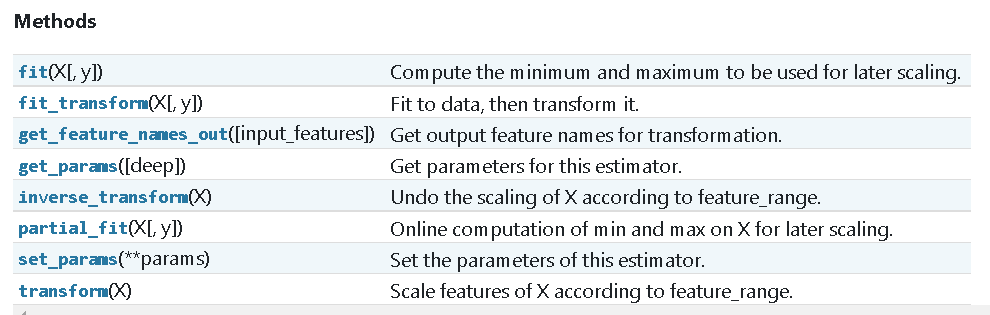

In [7]:
df_close.shape

(1258, 1)

In [8]:
df_close[:3]

array([[0.17607447],
       [0.17495567],
       [0.16862282]])

In [9]:
##splitting dataset into train and test split
training_size=int(len(df_close)*0.65)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size],df_close[training_size:len(df_close)]

In [10]:
len(train_data)

817

In [11]:
len(test_data)

441

In [12]:
train_data[:5]

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       [0.1696994 ],
       [0.16727181]])

In [13]:

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.12.0'

In [14]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index: int)-> Tuple[torch.Tensor, torch.Tensor] :
        x = self.data[index : index+self.seq_len]
        y = self.data[index+self.seq_len]
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        return  x, y


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data)

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size)
test_dataloader = DataLoader(test_dataset,batch_size)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x23a987e0730>,
 <torch.utils.data.dataloader.DataLoader at 0x23a987e06d0>)

In [15]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [16]:
from tqdm.auto import tqdm
import timeit

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        batch_size, seq_len, feature = X.shape
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred.reshape(batch_size), y.reshape(batch_size))
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        #delta_y = y.detach().cpu().numpy() - y_pred.detach().cpu().numpy()
        #train_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    #train_acc = train_acc / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            batch_size, seq_len, feature = X.shape

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits.reshape(batch_size), y.reshape(batch_size))
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            #delta_y = y.detach().cpu().numpy() - test_pred_logits.detach().cpu().numpy()
            #test_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    #test_acc = test_acc / len(dataloader)
    return test_loss

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    
    # track accuracy (if it doesn't increase, reducr the learning rate)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)
    
    #early_stop_count=0
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        start = timeit.default_timer()
        train_loss = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        stop = timeit.default_timer()

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"time (sec): {stop-start:.2f}"
        )
        
        #scheduler.step(test_loss) # monitor test accuracy
        
        # early stopping
        #if epoch==0:
            #pass
        #else:
            #if  results["test_loss"][-1]-test_loss <= 0.005:
                #early_stop_count+=1
                #if early_stop_count==4:
                    #print('early stopping!')
                    #break
            #else:
                #early_stop_count=0
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        
                
    # Return the filled results at the end of the epochs
    return results

In [17]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "test_loss": [...],}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]


    epochs = range(1, len(results["train_loss"])+1)

    plt.figure(figsize=(15, 7))
    # Plot loss
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.xticks(epochs)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    print('average train loss:', sum(loss)/len(loss))
    print('average test loss:', sum(test_loss)/len(test_loss))

In [18]:
class stackedLstm(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_size: int, hidden_size : int, num_layers : int) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstms = nn.LSTM(input_size = self.input_size, hidden_size =self.hidden_size, num_layers  = self.num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
        
        
    def forward(self, x):
        output, (h,c) = self.lstms(x)
        output = output[:, -1, :] # [batch, seq lenght, hidden units]
        output = self.linear(output)
        return output

    

In [19]:
set_seeds()
model_test1 = stackedLstm(input_size=1, hidden_size=50, num_layers =3).to(device)

In [20]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_test1, 
        input_size=(64, 100, 1), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
stackedLstm (stackedLstm)                [64, 100, 1]    [64, 1]         --              True
├─LSTM (lstms)                           [64, 100, 1]    [64, 100, 50]   51,400          True
├─Linear (linear)                        [64, 50]        [64, 1]         51              True
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
Total mult-adds (M): 328.96
Input size (MB): 0.03
Forward/backward pass size (MB): 2.56
Params size (MB): 0.21
Estimated Total Size (MB): 2.79

In [21]:
set_seeds()
inp = torch.randn(64, 100, 1).to(device)
with torch.inference_mode():
    out = model_test1(inp)
    #print(len(out[:][0])) = 100
    #print(out)
    #out = out[:, 99].squeeze()
    #print(out)

In [22]:
out.shape

torch.Size([64, 1])

In [23]:
#out

In [24]:
# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_test1.parameters(), lr=1e-3)
set_seeds()
results = train(model=model_test1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=30,
                       device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0241 | test_loss: 0.1866 | time (sec): 0.47
Epoch: 2 | train_loss: 0.0335 | test_loss: 0.2149 | time (sec): 0.10
Epoch: 3 | train_loss: 0.0263 | test_loss: 0.2254 | time (sec): 0.10
Epoch: 4 | train_loss: 0.0237 | test_loss: 0.2137 | time (sec): 0.10
Epoch: 5 | train_loss: 0.0235 | test_loss: 0.2023 | time (sec): 0.10
Epoch: 6 | train_loss: 0.0237 | test_loss: 0.1948 | time (sec): 0.09
Epoch: 7 | train_loss: 0.0229 | test_loss: 0.1800 | time (sec): 0.09
Epoch: 8 | train_loss: 0.0205 | test_loss: 0.1241 | time (sec): 0.09
Epoch: 9 | train_loss: 0.0118 | test_loss: 0.0425 | time (sec): 0.10
Epoch: 10 | train_loss: 0.0063 | test_loss: 0.0435 | time (sec): 0.09
Epoch: 11 | train_loss: 0.0039 | test_loss: 0.0504 | time (sec): 0.10
Epoch: 12 | train_loss: 0.0018 | test_loss: 0.0335 | time (sec): 0.09
Epoch: 13 | train_loss: 0.0042 | test_loss: 0.0356 | time (sec): 0.09
Epoch: 14 | train_loss: 0.0047 | test_loss: 0.0270 | time (sec): 0.10
Epoch: 15 | train_loss: 0.006

average train loss: 0.010212477943625547
average test loss: 0.0705380431984344


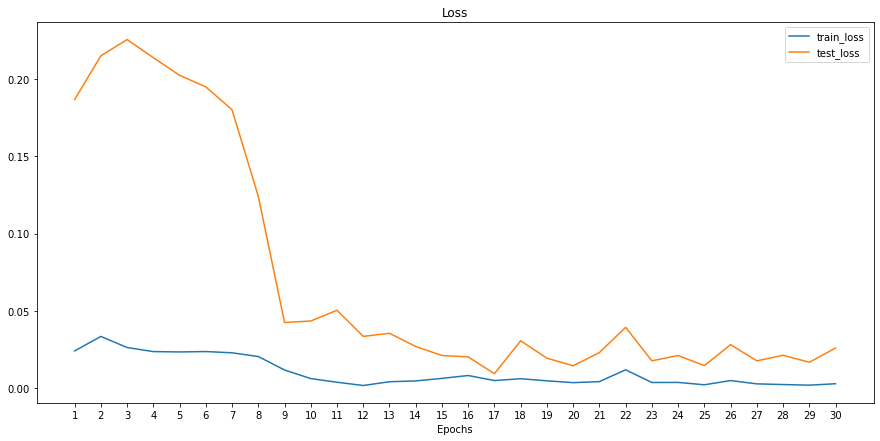

In [25]:
plot_loss_curves(results)

In [26]:
y_preds = []
y_trues = []
#hn , cn = model.init()
model_test1.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(test_dataloader):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    batch_size, seq_len, feature = X.shape
    # Do the forward pass
    out  = model_test1(X)
    y_pred = out.reshape(batch_size)
    y_preds.append(y_pred.cpu())
    y_trues.append(y.cpu())
y_pred_tensor_test = torch.cat(y_preds).cpu().numpy().reshape(-1, 1)
#print(y_pred_tensor)
y_true_tensor_test = torch.cat(y_trues).cpu().numpy().reshape(-1, 1)
#print(y_true_tensor)
y_pred_tensor_test = scaler.inverse_transform(y_pred_tensor_test)
y_true_tensor_test = scaler.inverse_transform(y_true_tensor_test)
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print('test rmse loss:', math.sqrt(mean_squared_error(y_pred_tensor_test,y_true_tensor_test)))

test rmse loss: 33.867366817576034


In [27]:
y_preds = []
y_trues = []
#hn , cn = model.init()
model_test1.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(train_dataloader):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    batch_size, seq_len, feature = X.shape
    # Do the forward pass
    out  = model_test1(X)
    y_pred = out.reshape(batch_size)
    y_preds.append(y_pred.cpu())
    y_trues.append(y.cpu())
y_pred_tensor_train = torch.cat(y_preds).cpu().numpy().reshape(-1, 1)
#print(y_pred_tensor)
y_true_tensor_train = torch.cat(y_trues).cpu().numpy().reshape(-1, 1)
#print(y_true_tensor)
y_pred_tensor_train = scaler.inverse_transform(y_pred_tensor_train)
y_true_tensor_train = scaler.inverse_transform(y_true_tensor_train)
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print('train rmse loss:', math.sqrt(mean_squared_error(y_pred_tensor_train,y_true_tensor_train)))

train rmse loss: 7.469588101021754


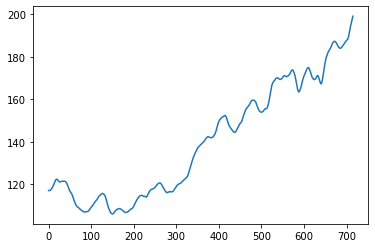

In [28]:
plt.plot(y_pred_tensor_train)

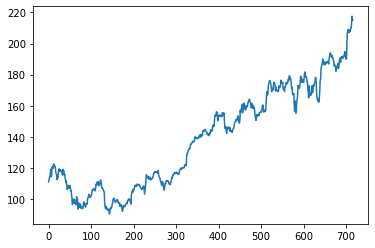

In [29]:
plt.plot(scaler.inverse_transform(df_close)[100:len(y_pred_tensor_train)+101])

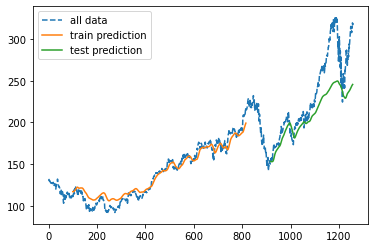

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_pred_tensor_train)+look_back, :] = y_pred_tensor_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_pred_tensor_train)+(look_back*2)+1:len(df_close)-1, :] = y_pred_tensor_test
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close), '--', label='all data')
plt.plot(trainPredictPlot, '-', label='train prediction')
plt.plot(testPredictPlot, '-', label='test prediction')
plt.legend()
plt.show()

## keras method

In [31]:
df1=df.reset_index()['close']

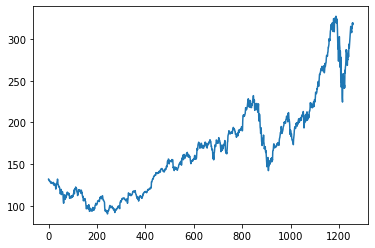

In [32]:

plt.plot(df1)

In [33]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [35]:
training_size,test_size

(817, 441)

In [36]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [37]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [38]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [39]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [40]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [41]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [42]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=30,batch_size=64,verbose=1)

Epoch 1/30
12/12 [==============================] - 6s 139ms/step - loss: 0.0175 - val_loss: 0.0659
Epoch 2/30
12/12 [==============================] - 0s 29ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 3/30
12/12 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 4/30
12/12 [==============================] - 0s 29ms/step - loss: 8.8786e-04 - val_loss: 0.0092
Epoch 5/30
12/12 [==============================] - 0s 30ms/step - loss: 8.1800e-04 - val_loss: 0.0077
Epoch 6/30
12/12 [==============================] - 0s 30ms/step - loss: 7.0490e-04 - val_loss: 0.0047
Epoch 7/30
12/12 [==============================] - 0s 28ms/step - loss: 6.1974e-04 - val_loss: 0.0043
Epoch 8/30
12/12 [==============================] - 0s 30ms/step - loss: 6.2405e-04 - val_loss: 0.0046
Epoch 9/30
12/12 [==============================] - 0s 29ms/step - loss: 6.0566e-04 - val_loss: 0.0047
Epoch 10/30
12/12 [==============================] - 0s 31ms/step - loss: 5.9995e-04

In [45]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 11ms/step


In [46]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [47]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

141.64570376450473

In [48]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

234.53441272564763

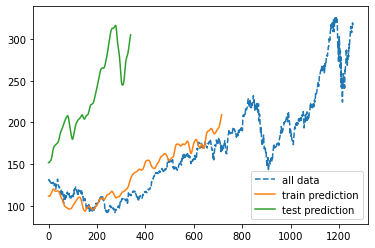

In [49]:
# plot baseline and predictions -> need to shift graph
plt.plot(scaler.inverse_transform(df1),'--', label='all data')
plt.plot(train_predict, '-', label='train prediction')
plt.plot(test_predict, '-', label='test prediction')
plt.legend()
plt.show()

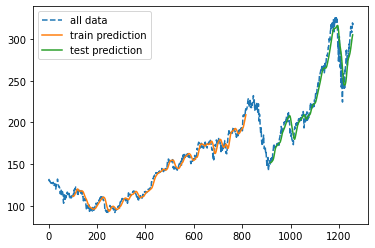

In [50]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1),'--', label='all data')
plt.plot(trainPredictPlot, '-', label='train prediction')
plt.plot(testPredictPlot, '-', label='test prediction')
plt.legend()
plt.show()

In [51]:
len(test_data)

441

In [52]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [53]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [54]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.9172908]
101
1 day output [[0.9214883]]
2 day output [[0.92414474]]
3 day output [[0.9253652]]
4 day output [[0.9253925]]
5 day output [[0.924507]]
6 day output [[0.9229696]]
7 day output [[0.92099595]]
8 day output [[0.9187504]]
9 day output [[0.91635]]
10 day output [[0.91387284]]
11 day output [[0.9113678]]
12 day output [[0.908864]]
13 day output [[0.90637684]]
14 day output [[0.90391445]]
15 day output [[0.9014801]]
16 day output [[0.89907515]]
17 day output [[0.8966999]]
18 day output [[0.89435506]]
19 day output [[0.8920407]]
20 day output [[0.8897579]]
21 day output [[0.8875072]]
22 day output [[0.8852893]]
23 day output [[0.88310504]]
24 day output [[0.8809551]]
25 day output [[0.87883973]]
26 day output [[0.8767594]]
27 day output [[0.874714]]
28 day output [[0.8727038]]
29 day output [[0.87072825]]


In [55]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [56]:
len(df1)

1258

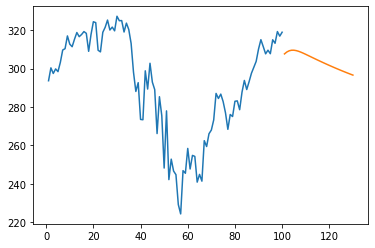

In [57]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

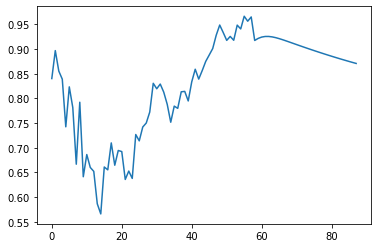

In [58]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

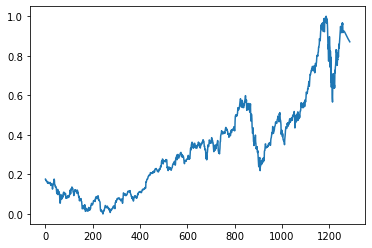

In [59]:
plt.plot(df3)

# more than 1 input features time series

In [60]:
df.columns

Index(['Unnamed: 0', 'symbol', 'date', 'close', 'high', 'low', 'open',
       'volume', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume',
       'divCash', 'splitFactor'],
      dtype='object')

In [61]:
target_columns = ['close', 'high', 'low', 'open', 'volume']
selected_data = df[target_columns]
selected_data

,close,high,low,open,volume
0,132.045,132.260,130.0500,130.34,45833246
1,131.780,131.950,131.1000,131.86,30733309
2,130.280,131.450,129.9000,131.23,50884452
3,130.535,131.390,130.0500,131.20,32112797
4,129.960,130.655,129.3200,129.86,33667627
...,...,...,...,...,...
1253,314.960,316.500,310.3241,313.17,33843125
1254,313.140,318.520,313.0100,315.03,25432385
1255,319.230,319.520,316.2000,316.68,27876215
1256,316.850,320.890,315.8700,318.66,25672211


In [62]:
scaler=MinMaxScaler(feature_range=(0,1))
scaler.fit(selected_data)
selected_data = pd.DataFrame(scaler.transform(selected_data),
                            index = selected_data.index,
                            columns = selected_data.columns)
selected_data

,close,high,low,open,volume
0,0.176074,0.171860,0.173508,0.171857,0.228522
1,0.174956,0.170548,0.177997,0.178333,0.128419
2,0.168623,0.168431,0.172866,0.175649,0.262008
3,0.169699,0.168177,0.173508,0.175521,0.137564
4,0.167272,0.165065,0.170387,0.169812,0.147872
...,...,...,...,...,...
1253,0.948324,0.951943,0.944305,0.950752,0.149035
1254,0.940640,0.960496,0.955789,0.958676,0.093277
1255,0.966351,0.964730,0.969429,0.965705,0.109478
1256,0.956303,0.970531,0.968018,0.974141,0.094867


In [63]:
train_size = int(len(selected_data)*0.65)
train_dataFrame = selected_data[:train_size]
test_dataFrame = selected_data[train_size:]
len(train_dataFrame), len(test_dataFrame)

(817, 441)

In [64]:
# test dataset
test_example = train_dataFrame[:100]
test_example

,close,high,low,open,volume
0,0.176074,0.171860,0.173508,0.171857,0.228522
1,0.174956,0.170548,0.177997,0.178333,0.128419
2,0.168623,0.168431,0.172866,0.175649,0.262008
3,0.169699,0.168177,0.173508,0.175521,0.137564
4,0.167272,0.165065,0.170387,0.169812,0.147872
...,...,...,...,...,...
95,0.091953,0.087264,0.085599,0.085204,0.274482
96,0.089758,0.089254,0.093937,0.096835,0.126655
97,0.090560,0.087984,0.090688,0.088698,0.143772
98,0.083889,0.084046,0.085899,0.090700,0.219434


In [65]:
test_example[target_columns].values[:10]

array([[0.17607447, 0.17186045, 0.17350778, 0.17185703, 0.22852181],
       [0.17495567, 0.17054789, 0.17799726, 0.17833255, 0.12841898],
       [0.16862282, 0.16843086, 0.17286643, 0.17564862, 0.26200805],
       [0.1696994 , 0.16817681, 0.17350778, 0.17552081, 0.13756409],
       [0.16727181, 0.16506478, 0.17038652, 0.16981212, 0.14787161],
       [0.16794731, 0.16627149, 0.17286643, 0.1732203 , 0.13007786],
       [0.16473866, 0.16474723, 0.16863349, 0.16861926, 0.17957644],
       [0.16174111, 0.16097891, 0.16628185, 0.16827845, 0.16085966],
       [0.1581525 , 0.15894657, 0.15974004, 0.16572232, 0.27387681],
       [0.15654817, 0.15416208, 0.15456644, 0.15634985, 0.29642082]])

In [66]:
test_example.values[:10]

array([[0.17607447, 0.17186045, 0.17350778, 0.17185703, 0.22852181],
       [0.17495567, 0.17054789, 0.17799726, 0.17833255, 0.12841898],
       [0.16862282, 0.16843086, 0.17286643, 0.17564862, 0.26200805],
       [0.1696994 , 0.16817681, 0.17350778, 0.17552081, 0.13756409],
       [0.16727181, 0.16506478, 0.17038652, 0.16981212, 0.14787161],
       [0.16794731, 0.16627149, 0.17286643, 0.1732203 , 0.13007786],
       [0.16473866, 0.16474723, 0.16863349, 0.16861926, 0.17957644],
       [0.16174111, 0.16097891, 0.16628185, 0.16827845, 0.16085966],
       [0.1581525 , 0.15894657, 0.15974004, 0.16572232, 0.27387681],
       [0.15654817, 0.15416208, 0.15456644, 0.15634985, 0.29642082]])

In [67]:
torch.from_numpy(test_example.values[:10])

tensor([[0.1761, 0.1719, 0.1735, 0.1719, 0.2285],
        [0.1750, 0.1705, 0.1780, 0.1783, 0.1284],
        [0.1686, 0.1684, 0.1729, 0.1756, 0.2620],
        [0.1697, 0.1682, 0.1735, 0.1755, 0.1376],
        [0.1673, 0.1651, 0.1704, 0.1698, 0.1479],
        [0.1679, 0.1663, 0.1729, 0.1732, 0.1301],
        [0.1647, 0.1647, 0.1686, 0.1686, 0.1796],
        [0.1617, 0.1610, 0.1663, 0.1683, 0.1609],
        [0.1582, 0.1589, 0.1597, 0.1657, 0.2739],
        [0.1565, 0.1542, 0.1546, 0.1563, 0.2964]], dtype=torch.float64)

In [68]:
torch.from_numpy(test_example.values[:10]).float()

tensor([[0.1761, 0.1719, 0.1735, 0.1719, 0.2285],
        [0.1750, 0.1705, 0.1780, 0.1783, 0.1284],
        [0.1686, 0.1684, 0.1729, 0.1756, 0.2620],
        [0.1697, 0.1682, 0.1735, 0.1755, 0.1376],
        [0.1673, 0.1651, 0.1704, 0.1698, 0.1479],
        [0.1679, 0.1663, 0.1729, 0.1732, 0.1301],
        [0.1647, 0.1647, 0.1686, 0.1686, 0.1796],
        [0.1617, 0.1610, 0.1663, 0.1683, 0.1609],
        [0.1582, 0.1589, 0.1597, 0.1657, 0.2739],
        [0.1565, 0.1542, 0.1546, 0.1563, 0.2964]])

In [69]:
test_example.iloc[1]['close']

0.17495567001604323

In [70]:
torch.from_numpy(np.array(test_example.iloc[1]['close']))

tensor(0.1750, dtype=torch.float64)

In [71]:
# custom dataset
class StockDataset(Dataset):
    def __init__(self,data, target_column, seq_len = 100):
        self.data = data
        self.seq_len = seq_len
        self.target_column = target_column
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index: int)-> Tuple[torch.Tensor, torch.Tensor] :
        x = self.data[index : index+self.seq_len].values
        y = self.data.iloc[index+self.seq_len][self.target_column]
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(np.array(y)).float()
        return  x, y

In [72]:
train_dataset = StockDataset(train_dataFrame, 'close') 
test_dataset = StockDataset(test_dataFrame, 'close')

batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size)
test_dataloader = DataLoader(test_dataset,batch_size)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x23bc82c1d60>,
 <torch.utils.data.dataloader.DataLoader at 0x23bc82c1eb0>)

In [73]:
set_seeds()
model_test1 = stackedLstm(input_size=len(target_columns), hidden_size=50, num_layers =3).to(device)

In [74]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_test1, 
        input_size=(64, 100, len(target_columns)), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
stackedLstm (stackedLstm)                [64, 100, 5]    [64, 1]         --              True
├─LSTM (lstms)                           [64, 100, 5]    [64, 100, 50]   52,200          True
├─Linear (linear)                        [64, 50]        [64, 1]         51              True
Total params: 52,251
Trainable params: 52,251
Non-trainable params: 0
Total mult-adds (M): 334.08
Input size (MB): 0.13
Forward/backward pass size (MB): 2.56
Params size (MB): 0.21
Estimated Total Size (MB): 2.90

In [75]:
# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_test1.parameters(), lr=1e-3)
set_seeds()
results = train(model=model_test1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=30,
                       device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0343 | test_loss: 0.2460 | time (sec): 0.32
Epoch: 2 | train_loss: 0.0190 | test_loss: 0.1814 | time (sec): 0.19
Epoch: 3 | train_loss: 0.0243 | test_loss: 0.1770 | time (sec): 0.19
Epoch: 4 | train_loss: 0.0217 | test_loss: 0.1552 | time (sec): 0.19
Epoch: 5 | train_loss: 0.0139 | test_loss: 0.0427 | time (sec): 0.19
Epoch: 6 | train_loss: 0.0109 | test_loss: 0.0169 | time (sec): 0.19
Epoch: 7 | train_loss: 0.0040 | test_loss: 0.0065 | time (sec): 0.19
Epoch: 8 | train_loss: 0.0031 | test_loss: 0.0289 | time (sec): 0.19
Epoch: 9 | train_loss: 0.0034 | test_loss: 0.0231 | time (sec): 0.19
Epoch: 10 | train_loss: 0.0050 | test_loss: 0.0395 | time (sec): 0.19
Epoch: 11 | train_loss: 0.0026 | test_loss: 0.0230 | time (sec): 0.20
Epoch: 12 | train_loss: 0.0030 | test_loss: 0.0412 | time (sec): 0.19
Epoch: 13 | train_loss: 0.0015 | test_loss: 0.0223 | time (sec): 0.20
Epoch: 14 | train_loss: 0.0013 | test_loss: 0.0316 | time (sec): 0.19
Epoch: 15 | train_loss: 0.001

average train loss: 0.00583659639297467
average test loss: 0.04429117312392918


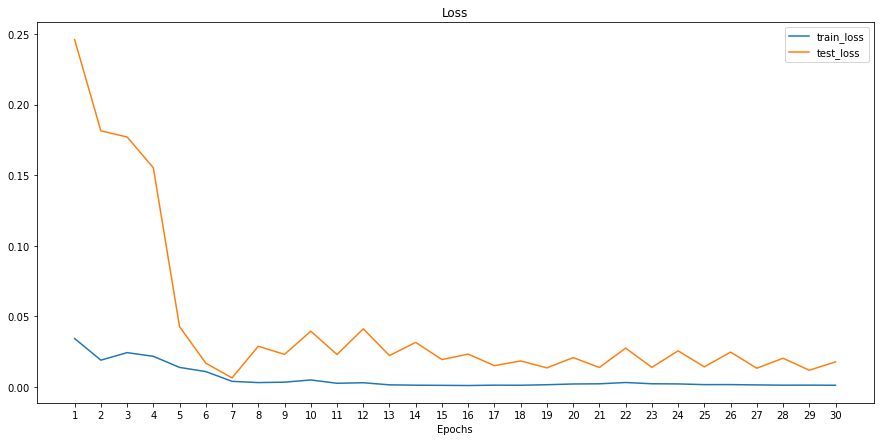

In [76]:
plot_loss_curves(results)

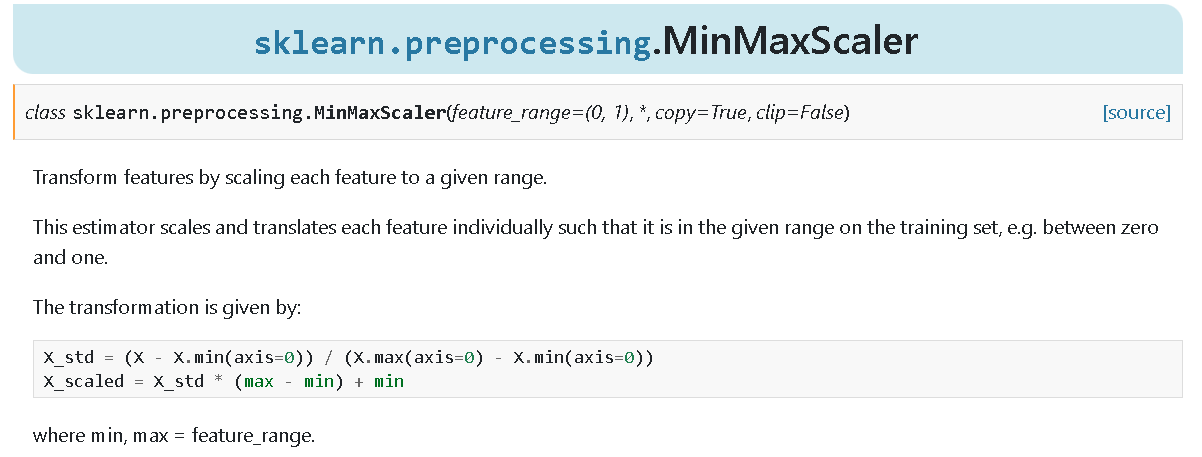

In [77]:
scaler.scale_

array([4.22190323e-03, 4.23405877e-03, 4.27569694e-03, 4.26021386e-03,
       6.62935458e-09])

In [78]:
scaler.feature_names_in_

array(['close', 'high', 'low', 'open', 'volume'], dtype=object)

In [79]:
y_preds = []
y_trues = []
#hn , cn = model.init()
model_test1.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(test_dataloader):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    batch_size, seq_len, feature = X.shape
    # Do the forward pass
    out  = model_test1(X)
    y_pred = out.reshape(batch_size)
    y_preds.append(y_pred.cpu())
    y_trues.append(y.cpu())
y_pred_tensor_test = torch.cat(y_preds).cpu().numpy().reshape(-1, 1)
#print(y_pred_tensor)
y_true_tensor_test = torch.cat(y_trues).cpu().numpy().reshape(-1, 1)
#print(y_true_tensor)
y_pred_tensor_test = y_pred_tensor_test/scaler.scale_[0]
y_true_tensor_test = y_true_tensor_test/scaler.scale_[0]
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print('test rmse loss:', math.sqrt(mean_squared_error(y_pred_tensor_test,y_true_tensor_test)))

test rmse loss: 27.896555960775093


In [80]:
y_preds = []
y_trues = []
#hn , cn = model.init()
model_test1.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(train_dataloader):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    batch_size, seq_len, feature = X.shape
    # Do the forward pass
    out  = model_test1(X)
    y_pred = out.reshape(batch_size)
    y_preds.append(y_pred.cpu())
    y_trues.append(y.cpu())
y_pred_tensor_train = torch.cat(y_preds).cpu().numpy().reshape(-1, 1)
#print(y_pred_tensor)
y_true_tensor_train = torch.cat(y_trues).cpu().numpy().reshape(-1, 1)
#print(y_true_tensor)
y_pred_tensor_train = y_pred_tensor_train/scaler.scale_[0]
y_true_tensor_train = y_true_tensor_train/scaler.scale_[0]
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print('train rmse loss:', math.sqrt(mean_squared_error(y_pred_tensor_train,y_true_tensor_train)))

train rmse loss: 6.3291855665087535


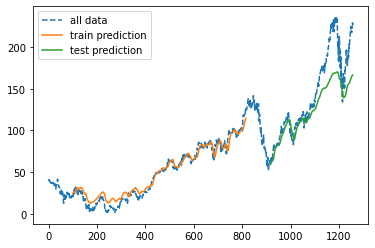

In [81]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_pred_tensor_train)+look_back, :] = y_pred_tensor_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_pred_tensor_train)+(look_back*2)+1:len(df_close)-1, :] = y_pred_tensor_test
# plot baseline and predictions
plt.plot(df_close/scaler.scale_[0], '--', label='all data')
plt.plot(trainPredictPlot, '-', label='train prediction')
plt.plot(testPredictPlot, '-', label='test prediction')
plt.legend()
plt.show()